# Resume run and load data

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
[INFO]: Training data loader called
[INFO]: processing subjects: [9, 11]
samples - 8695
[INFO]: Validation data loader called
[INFO]: processing subjects: [9, 11]
samples - 8695
[INFO]: Start training procedure using device: cuda
[INFO]: Monitoring: Encoder2D
[INFO]: Monitoring: Decoder3D
[INFO]: Monitoring: critic


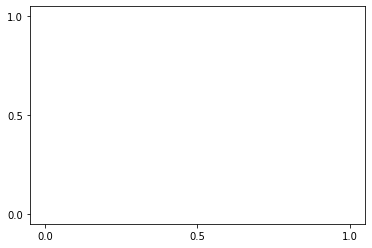

In [1]:
%load_ext autoreload
%autoreload 2

import atexit
import gc
import math
import os
import sys
from argparse import ArgumentParser

import numpy as np
import torch
import wandb

from src import train_utils
from src import viz
from src.dataloader import train_dataloader, val_dataloader
from src.models import PJPE, weight_init, Critic
from src.trainer import _validation_step
from src.callbacks import CallbackList, ModelCheckpoint, Logging, WeightScheduler, Analyze, MaxNorm
from src.train import training_specific_args
from collections import defaultdict
from src.processing import post_process
import src.viz.mpl_plots as plot
from src.viz.mpl_plots import plot_all_proj
import matplotlib.pyplot as plt

import sys; sys.argv=['']; del sys

# Experiment Configuration, Config, is distributed to all the other modules
parser = training_specific_args()
config = parser.parse_args()
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# GPU setup
use_cuda = config.cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
config.device = device  # Adding device to config, not already in argparse
config.num_workers = 4 if use_cuda else 4  # for dataloader

# ignore when debugging on cpu
if not use_cuda:
    # os.environ['WANDB_MODE'] = 'dryrun'  # Doesnt auto sync to project
    os.environ['WANDB_TAGS'] = 'CPU'
    wandb.init(anonymous='allow', project="hpe3d", config=config)  # to_delete
else:
    os.environ['WANDB_MODE'] = 'dryrun'
    wandb.init(anonymous='allow', project="hpe3d", config=config)

config.logger = wandb
config.logger.run.save()
config.run_name = config.logger.run.name  # handle name change in wandb
# Data loading
config.train_subjects = [9, 11]
train_loader = train_dataloader(config)
config.val_subjects = [9, 11]
val_loader = val_dataloader(config)

variant = [['2d', '3d']]

models = train_utils.get_models(variant, config)  # model instances
if config.self_supervised:
    critic = Critic()
    models['Critic'] = critic
optimizers = train_utils.get_optims(variant, models, config)  # optimer for each pair
schedulers = train_utils.get_schedulers(optimizers)

# For multiple GPUs
if torch.cuda.device_count() > 1:
    print(f'[INFO]: Using {torch.cuda.device_count()} GPUs')
    for key in models.keys():
        models[key] = torch.nn.DataParallel(models[key])

# To CPU or GPU or TODO TPU
for key in models.keys():
    models[key] = models[key].to(device)
    # models[key].apply(weight_init)

config.mpjpe_min=float('inf')
config.mpjpe_at_min_val=float('inf')
#*******************************************************************#
config.resume_run = "None"

# initiate all required callbacks, keep the order in mind!!!
cb = CallbackList([ModelCheckpoint(),
                    Logging(),                       
                    WeightScheduler(config, strategy="beta_cycling"),
                    # Analyze(500),
                    ])

cb.setup(config = config, models = models, optimizers = optimizers,
            train_loader = train_loader, val_loader = val_loader, variant = variant)

n_pair=1
pair=variant[0]
vae_type="_2_".join(pair)
# model -- encoder, decoder / critic
model=[models[f"Encoder{pair[0].upper()}"],
            models[f"Decoder{pair[1].upper()}"]]
optimizer = [optimizers[n_pair]]
scheduler = [schedulers[n_pair]]

if config.self_supervised:
    model.append(models['Critic'])
    optimizer.append(optimizers[-1])
    scheduler.append(schedulers[-1])


# Run validation epoch and get metrics

In [4]:
# Validation epoch code

cb.on_validation_start()

t_data = defaultdict(list)
loss_dic = defaultdict(int)
normalize_pose = True
epoch = 1
with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        for key in batch.keys():
            batch[key] = batch[key].to(config.device)

        output = _validation_step(batch, batch_idx, model, epoch, config)

        loss_dic['loss'] += output['loss'].item()
        loss_dic['recon_loss'] += output['log']['recon_loss'].item()
        loss_dic['kld_loss'] += output['log']['kld_loss'].item()

        if config.self_supervised:
            loss_dic['gen_loss'] += output['log']['gen_loss'].item()
            loss_dic['critic_loss'] += output['log']['critic_loss'].item()
            loss_dic['D_x'] += output['log']['D_x']
            loss_dic['D_G_z1'] += output['log']['D_G_z1']
            loss_dic['D_G_z2'] += output['log']['D_G_z2']

        for key in output['data'].keys():
            t_data[key].append(output['data'][key])

        del output
        gc.collect()

avg_loss = loss_dic['loss']/len(val_loader)  # return for scheduler

for key in t_data.keys():
    t_data[key] = torch.cat(t_data[key], 0)

# performance
t_data['recon_3d_org'] = t_data['recon_3d'].detach()
if '3D' in model[1].name:
    if normalize_pose and not config.self_supervised:
        t_data['recon_3d'], t_data['target_3d'] = post_process(
            t_data['recon_3d'], t_data['target_3d'])

    elif config.self_supervised:
        t_data['recon_3d'], t_data['target_3d'] = post_process(
            t_data['recon_3d'].to('cpu'), t_data['target_3d'].to('cpu'),
           
            self_supervised=True, procrustes_enabled=False)

    # Speed up procrustes alignment with CPU!
    t_data['recon_3d']=t_data['recon_3d'].to('cuda')
    t_data['target_3d']=t_data['target_3d'].to('cuda')

    pjpe_ = PJPE(t_data['recon_3d'], t_data['target_3d'])
    avg_pjpe = torch.mean((pjpe_), dim=0)
    avg_mpjpe = torch.mean(avg_pjpe).item()
    pjpe = torch.mean(pjpe_, dim=1)

    config.logger.log({"pjpe": pjpe.cpu()})

    # average epochs output
    avg_output = {}
    avg_output['log'] = {}

    avg_output['loss'] = loss_dic['loss']/len(val_loader)
    avg_output['log']['recon_loss'] = loss_dic['recon_loss']/len(val_loader)
    avg_output['log']['kld_loss'] = loss_dic['kld_loss']/len(val_loader)

    # print to console
    print(f"{vae_type} Validation:",
            f"\t\tLoss: {round(avg_output['loss'],4)}",
            f"\tReCon: {round(avg_output['log']['recon_loss'], 4)}",
            f"\tKLD: {round(avg_output['log']['kld_loss'], 4)}", end='')

Start validation epoch
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2d_2_3d Validation: 		Loss: -0.1263 	ReCon: 0.0382 	KLD: 0.0212Error in callback <function _init_jupyter.<locals>.cleanup at 0x7fa2b207f4d0> (for post_run_cell):


NotebookValidationError: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01t\x00\x00\x00\xf8\x08\x06\x00\x00\x00\xfcf\x1dD\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.1.3, http://matplotlib.org/\x80\x001D\x00\x00\x08~IDATx\x9c\xed\xddA\xa8\xa5u\x19\xc7\xf1\xdf\x93V\xcb\x82\xe6.D\xa5+\xe4\xa6\x85\x84^\xa4\xa5\x10\x81\xbap\x16\x15\xd8\xc6\x94d6\x89kW\x05\xeeZ\x05A$Z\xa2\xb6P\xc1\xd5\x04B\x10-\\\x15^!\xc4\x12a\x10\xc4\x8b\x82W\r7\x911\xf0\xb4\x98\x13]\xaeg\xe6\x9e\x999\xc7;\xf7\xe9\xf3\x81\x03\xe7=\xef;\xe7}\x16\x7f\xbe\xbc\xf7p\xce\xbc\xd5\xdd\x01\xe0\xe4\xfb\xc2q\x0f\x00\xc0z\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\\\x7f\\\'>u\xeaTooo\x1f\xd7\xe9\x01N\xa4\xd7^{\xed\xc3\xee\xdeZ\xb6\xef\xd8\x82\xbe\xbd\xbd\x9d\xdd\xdd\xdd\xe3:=\xc0\x89TU\xef\\l\x9f\x8f\\\x00\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x8682\xe8U\xf5tU}PUo\\d\x7fU\xd5/\xab\xea\\U\xbd^U\xb7\xaf\x7fL\x00\x8e\xb2\xca\x15\xfa3I\xee\xbe\xc4\xfe{\x92\xdc\xbax\x9cI\xf2\xeb\xab\x1f\x0b\x80\xcbud\xd0\xbb\xfb\x95$\x1f_\xe2\x90\xd3I\x9e\xeb\x0b\xfe\x9c\xe4\xabUu\xc3\xba\x06\x04`5\xeb\xf8\x0c\xfd\xc6$\xef\x1e\xd8\xde[\xbc\xf6\x19Uu\xa6\xaav\xabjw\x7f\x7f\x7f\r\xa7\x06\xe0\xbf\xd6\x11\xf4Z\xf2\xda\xd2\xbbft\xf7\x93\xdd\xbd\xd3\xdd;[[K\x7f\xb9\n\xc0\x15ZG\xd0\xf7\x92\xdc|`\xfb\xa6$\xef\xad\xe1}\x01\xb8\x0c\xeb\x08\xfa\xd9$\x0f,\xbe\xed\xf2\xed$\x9ft\xf7\xfbkx_\x00.\xc3\x91\xff9WU=\x9f\xe4\xae$\xa7\xaaj/\xc9\xcf\x92|1I\xba\xfb\x89$/\'\xb97\xc9\xb9$\xffL\xf2\xd0\xa6\x86\x05\xe0\xe2\x8e\x0czw\xff\xf0\x88\xfd\x9d\xe4\'k\x9b\x08\x80+\xe2\x97\xa2\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10+\x05\xbd\xaa\xee\xae\xaa\xb7\xaa\xea\\U=\xb6d\xff\x83U\xb5_U\x7f]<\x1e^\xff\xa8\x00\\\xca\xf5G\x1dPU\xd7%\xf9U\x92\xef&\xd9K\xf2jU\x9d\xed\xee\xbf\x1f:\xf4\xc5\xee~d\x033\x02\xb0\x82U\xae\xd0\xefLr\xae\xbb\xdf\xee\xee\x7f\'y!\xc9\xe9\xcd\x8e\x05\xc0\xe5Z%\xe87&y\xf7\xc0\xf6\xde\xe2\xb5\xc3\xbeWU\xafW\xd5KUu\xf3\xb27\xaa\xaa3U\xb5[U\xbb\xfb\xfb\xfbW0.\x00\x17\xb3J\xd0k\xc9k}h\xfb\xf7I\xb6\xbb\xfb\xb6$\x7fL\xf2\xec\xb27\xea\xee\'\xbb{\xa7\xbbw\xb6\xb6\xb6.oR\x00.i\x95\xa0\xef%9x\xc5}S\x92\xf7\x0e\x1e\xd0\xdd\x1fu\xf7\xa7\x8b\xcd\xa7\x92\xdc\xb1\x9e\xf1\x00X\xd5*A\x7f5\xc9\xadUuKU})\xc9\xfdI\xce\x1e<\xa0\xaan8\xb0y_\x927\xd77"\x00\xab8\xf2[.\xdd}\xbe\xaa\x1eI\xf2\x87$\xd7%y\xba\xbb\xffVU\x8f\'\xd9\xed\xee\xb3I\x1e\xad\xaa\xfb\x92\x9cO\xf2q\x92\x07783\x00KT\xf7\xe1\x8f\xc3?\x1f;;;\xbd\xbb\xbb{,\xe7\x068\xa9\xaa\xea\xb5\xee\xdeY\xb6\xcf/E\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!V\nzU\xdd]UoU\xd5\xb9\xaazl\xc9\xfe/W\xd5\x8b\x8b\xfd\x7f\xa9\xaa\xedu\x0f\n\xc0\xa5\x1d\x19\xf4\xaa\xba.\xc9\xaf\x92\xdc\x93\xe4\x9bI~XU\xdf<t\xd8\x8f\x93\xfc\xa3\xbb\xbf\x91\xe4\x17I~\xbe\xeeA\x01\xb8\xb4U\xae\xd0\xefLr\xae\xbb\xdf\xee\xee\x7f\'y!\xc9\xe9C\xc7\x9cN\xf2\xec\xe2\xf9KI\xbeSU\xb5\xbe1\x018\xca*A\xbf1\xc9\xbb\x07\xb6\xf7\x16\xaf-=\xa6\xbb\xcf\'\xf9$\xc9\xd7\x0e\xbfQU\x9d\xa9\xaa\xdd\xaa\xda\xdd\xdf\xdf\xbf\xb2\x89\x01Xj\x95\xa0/\xbb\xd2\xee+8&\xdd\xfddw\xeft\xf7\xce\xd6\xd6\xd6*\xf3\x01\xb0\xa2U\x82\xbe\x97\xe4\xe6\x03\xdb7%y\xefb\xc7T\xd5\xf5I\xbe\x92\xe4\xe3u\x0c\x08\xc0jV\t\xfa\xabIn\xad\xaa[\xaa\xeaKI\xeeOr\xf6\xd01g\x93\xfch\xf1\xfc\xfbI\xfe\xd4\xdd\x9f\xb9B\x07`s\xae?\xea\x80\xee>_U\x8f$\xf9C\x92\xeb\x92<\xdd\xdd\x7f\xab\xaa\xc7\x93\xecv\xf7\xd9$\xbfM\xf2\xbb\xaa:\x97\x0bW\xe6\xf7orh\x00>\xeb\xc8\xa0\'Iw\xbf\x9c\xe4\xe5C\xaf\xfd\xf4\xc0\xf3\x7f%\xf9\xc1zG\x03\xe0r\xf8\xa5(\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\xd4q}\xbb\xb0\xaa\xf6\x93\xbcs\x85\xff\xfcT\x92\x0f\xd78\x0e\x1cd}\xb1iW\xb3\xc6\xbe\xde\xddK\x7f\x99ylA\xbf\x1aU\xb5\xdb\xdd;\xc7=\x073Y_l\xda\xa6\xd6\x98\x8f\\\x00\x86\x10t\x80!Nj\xd0\x9f<\xee\x01\x18\xcd\xfab\xd36\xb2\xc6N\xe4g\xe8\x00|\xd6I\xbdB\x07\xe0\x10A\x07\x18\xe2\x9a\x0e\xba\x9bS\xb3I+\xac\xaf\x07\xabj\xbf\xaa\xfe\xbax<|\x1csr2U\xd5\xd3U\xf5AU\xbdq\x91\xfdUU\xbf\\\xac\xbf\xd7\xab\xea\xf6\xab=\xe75\x1bt7\xa7f\x93V\\_I\xf2bw\x7fk\xf1\xf8\xcd\xe7:$\'\xdd3I\xee\xbe\xc4\xfe{\x92\xdc\xbax\x9cI\xf2\xeb\xab=\xe15\x1b\xf4\xb895\x9b\xb5\xca\xfa\x82+\xd6\xdd\xaf\xe4\xd2wn;\x9d\xe4\xb9\xbe\xe0\xcfI\xbeZU7\\\xcd9\xaf\xe5\xa0\xaf\xed\xe6\xd4\xb0\xc4*\xeb+I\xbe\xb7\xf8s\xf8\xa5\xaa\xbay\xc9~\xb8R\xab\xae\xc1\x95]\xcbA_\xdb\xcd\xa9a\x89U\xd6\xce\xef\x93lw\xf7mI\xfe\x98\xff\xfd5\x08\xeb\xb0\xf6~]\xcbAwsj6\xe9\xc8\xf5\xd5\xdd\x1fu\xf7\xa7\x8b\xcd\xa7\x92\xdc\xf19\xcd\xc6\xff\x87U\x1awY\xae\xe5\xa0\xbb95\x9bt\xe4\xfa:\xf4y\xe6}I\xde\xfc\x1c\xe7c\xbe\xb3I\x1eX|\xdb\xe5\xdbI>\xe9\xee\xf7\xaf\xe6\rW\xba\xa7\xe8qpsj6i\xc5\xf5\xf5hU\xdd\x97\xe4|.\xac\xaf\x07\x8fm`N\x9c\xaaz>\xc9]INU\xd5^\x92\x9f%\xf9b\x92t\xf7\x13\xb9p\x9f\xe6{\x93\x9cK\xf2\xcf$\x0f]\xf59]\xd0\x02\xccp-\x7f\xe4\x02\xc0e\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x88\xff\x00\xf9x\xdb\xf2\xab\xf0\x86\x11\x00\x00\x00\x00IEND\xaeB`\x82' is not valid under any of the given schemas

Failed validating 'oneOf' in notebook['properties']['data']['additionalProperties']:

On instance['data']['image/png']:
(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01t\x00\x00\x00\xf8'
 b'\x08\x06\x00\x00\x00\xfcf\x1dD\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d'
 b'\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd'
 b'~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.1.3, http://matpl'
 b'otlib.org/\x80\x001D\x00\x00\x08~IDATx\x9c\xed\xddA\xa8\xa5u\x19\xc7'
 b'\xf1\xdf\x93V\xcb\x82\xe6.D\xa5+\xe4\xa6\x85\x84^\xa4\xa5\x10\x81'
 b'\xbap\x16\x15\xd8\xc6\x94d6\x89kW\x05\xeeZ\x05A$Z\xa2\xb6P\xc1\xd5'
 b'\x04B\x10-\\\x15^!\xc4\x12a\x10\xc4\x8b\x82W\r7\x911\xf0\xb4\x98\x13'
 b']\xaeg\xe6\x9e\x999\xc7;\xf7\xe9\xf3\x81\x03\xe7=\xef;\xe7}'
 b'\x16\x7f\xbe\xbc\xf7p\xce\xbc\xd5\xdd\x01\xe0\xe4\xfb\xc2q\x0f\x00\xc0z'
 b"\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\\\x7f\\'>u\xeaTo"
 b'oo\x1f\xd7\xe9\x01N\xa4\xd7^{\xed\xc3\xee\xdeZ\xb6\xef\xd8\x82'
 b'\xbe\xbd\xbd\x9d\xdd\xdd\xdd\xe3:=\xc0\x89TU\xef\\l\x9f\x8f\\\x00\x86\x10t'
 b'\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x8682\xe8U\xf5tU}PUo\\d\x7fU'
 b'\xd5/\xab\xea\\U\xbd^U\xb7\xaf\x7fL\x00\x8e\xb2\xca\x15\xfa3I\xee\xbe\xc4'
 b'\xfe{\x92\xdc\xbax\x9cI\xf2\xeb\xab\x1f\x0b\x80\xcbud\xd0\xbb\xfb'
 b'\x95$\x1f_\xe2\x90\xd3I\x9e\xeb\x0b\xfe\x9c\xe4\xabUu\xc3\xba\x06'
 b'\x04`5\xeb\xf8\x0c\xfd\xc6$\xef\x1e\xd8\xde[\xbc\xf6\x19Uu\xa6\xaav\xabj'
 b'w\x7f\x7f\x7f\r\xa7\x06\xe0\xbf\xd6\x11\xf4Z\xf2\xda\xd2\xbbft\xf7'
 b'\x93\xdd\xbd\xd3\xdd;[[K\x7f\xb9\n\xc0\x15ZG\xd0\xf7\x92\xdc|`\xfb\xa6'
 b'$\xef\xad\xe1}\x01\xb8\x0c\xeb\x08\xfa\xd9$\x0f,\xbe\xed\xf2\xed$'
 b'\x9ft\xf7\xfbkx_\x00.\xc3\x91\xff9WU=\x9f\xe4\xae$\xa7\xaaj/\xc9\xcf\x92|'
 b"1I\xba\xfb\x89$/'\xb97\xc9\xb9$\xffL\xf2\xd0\xa6\x86\x05\xe0\xe2\x8e\x0c"
 b"zw\xff\xf0\x88\xfd\x9d\xe4'k\x9b\x08\x80+\xe2\x97\xa2\x00C\x08"
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c'
 b'!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08'
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c'
 b'!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08'
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c'
 b'!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08'
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c'
 b'!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08'
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c'
 b'!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08'
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10+\x05\xbd\xaa\xee\xae\xaa'
 b'\xb7\xaa\xea\\U=\xb6d\xff\x83U\xb5_U\x7f]<\x1e^\xff\xa8\x00\\\xca'
 b'\xf5G\x1dPU\xd7%\xf9U\x92\xef&\xd9K\xf2jU\x9d\xed\xee\xbf\x1f:\xf4'
 b"\xc5\xee~d\x033\x02\xb0\x82U\xae\xd0\xefLr\xae\xbb\xdf\xee\xee\x7f'y!"
 b'\xc9\xe9\xcd\x8e\x05\xc0\xe5Z%\xe87&y\xf7\xc0\xf6\xde\xe2\xb5\xc3'
 b'\xbeWU\xafW\xd5KUu\xf3\xb27\xaa\xaa3U\xb5[U\xbb\xfb\xfb\xfbW0.\x00\x17'
 b'\xb3J\xd0k\xc9k}h\xfb\xf7I\xb6\xbb\xfb\xb6$\x7fL\xf2\xec\xb27\xea\xee'
 b"'\xbb{\xa7\xbbw\xb6\xb6\xb6.oR\x00.i\x95\xa0\xef%9x\xc5}S\x92\xf7\x0e\x1e"
 b'\xd0\xdd\x1fu\xf7\xa7\x8b\xcd\xa7\x92\xdc\xb1\x9e\xf1\x00X\xd5*A\x7f'
 b'5\xc9\xadUuKU})\xc9\xfdI\xce\x1e<\xa0\xaan8\xb0y_\x927\xd77"\x00\xab8\xf2['
 b".\xdd}\xbe\xaa\x1eI\xf2\x87$\xd7%y\xba\xbb\xffVU\x8f'\xd9\xed\xee\xb3"
 b'I\x1e\xad\xaa\xfb\x92\x9cO\xf2q\x92\x07783\x00KT\xf7\xe1\x8f\xc3?\x1f'
 b';;;\xbd\xbb\xbb{,\xe7\x068\xa9\xaa\xea\xb5\xee\xdeY\xb6\xcf/E\x01\x86'
 b'\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A'
 b'\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01'
 b'\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08'
 b'A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t'
 b'\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18'
 b'B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04'
 b'\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01'
 b'\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08'
 b'A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t'
 b'\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18'
 b'B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04'
 b'\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01'
 b'\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08'
 b'A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t'
 b'\x80!V\nzU\xdd]UoU\xd5\xb9\xaazl\xc9\xfe/W\xd5\x8b\x8b\xfd\x7f\xa9\xaa\xed'
 b'u\x0f\n\xc0\xa5\x1d\x19\xf4\xaa\xba.\xc9\xaf\x92\xdc\x93\xe4\x9bI~XU\xdf<'
 b't\xd8\x8f\x93\xfc\xa3\xbb\xbf\x91\xe4\x17I~\xbe\xeeA\x01\xb8\xb4U'
 b"\xae\xd0\xefLr\xae\xbb\xdf\xee\xee\x7f'y!\xc9\xe9C\xc7\x9cN"
 b'\xf2\xec\xe2\xf9KI\xbeSU\xb5\xbe1\x018\xca*A\xbf1\xc9\xbb\x07\xb6\xf7'
 b"\x16\xaf-=\xa6\xbb\xcf'\xf9$\xc9\xd7\x0e\xbfQU\x9d\xa9\xaa\xdd"
 b'\xaa\xda\xdd\xdf\xdf\xbf\xb2\x89\x01Xj\x95\xa0/\xbb\xd2\xee+8&\xdd\xfddw'
 b'\xeft\xf7\xce\xd6\xd6\xd6*\xf3\x01\xb0\xa2U\x82\xbe\x97\xe4\xe6\x03\xdb'
 b'7%y\xefb\xc7T\xd5\xf5I\xbe\x92\xe4\xe3u\x0c\x08\xc0jV\t\xfa\xabIn\xad\xaa['
 b'\xaa\xeaKI\xeeOr\xf6\xd01g\x93\xfch\xf1\xfc\xfbI\xfe\xd4\xdd\x9f\xb9B'
 b'\x07`s\xae?\xea\x80\xee>_U\x8f$\xf9C\x92\xeb\x92<\xdd\xdd\x7f\xab\xaa'
 b'\xc7\x93\xecv\xf7\xd9$\xbfM\xf2\xbb\xaa:\x97\x0bW\xe6\xf7orh\x00>\xeb'
 b"\xc8\xa0'Iw\xbf\x9c\xe4\xe5C\xaf\xfd\xf4\xc0\xf3\x7f%\xf9\xc1zG\x03\xe0r"
 b'\xf8\xa5(\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\xd4q}\xbb'
 b'\xb0\xaa\xf6\x93\xbcs\x85\xff\xfcT\x92\x0f\xd78\x0e\x1cd}\xb1i'
 b'W\xb3\xc6\xbe\xde\xddK\x7f\x99ylA\xbf\x1aU\xb5\xdb\xdd;\xc7=\x073Y'
 b'_l\xda\xa6\xd6\x98\x8f\\\x00\x86\x10t\x80!Nj\xd0\x9f<\xee\x01\x18\xcd\xfa'
 b'b\xd36\xb2\xc6N\xe4g\xe8\x00|\xd6I\xbdB\x07\xe0\x10A\x07\x18\xe2\x9a\x0e'
 b'\xba\x9bS\xb3I+\xac\xaf\x07\xabj\xbf\xaa\xfe\xbax<|\x1csr2U\xd5\xd3U\xf5A'
 b'U\xbdq\x91\xfdUU\xbf\\\xac\xbf\xd7\xab\xea\xf6\xab=\xe75\x1bt7\xa7f'
 b"\x93V\\_I\xf2bw\x7fk\xf1\xf8\xcd\xe7:$'\xdd3I\xee\xbe\xc4\xfe{\x92\xdc\xba"
 b'x\x9cI\xf2\xeb\xab=\xe15\x1b\xf4\xb895\x9b\xb5\xca\xfa\x82+'
 b'\xd6\xdd\xaf\xe4\xd2wn;\x9d\xe4\xb9\xbe\xe0\xcfI\xbeZU7\\\xcd9\xaf\xe5'
 b'\xa0\xaf\xed\xe6\xd4\xb0\xc4*\xeb+I\xbe\xb7\xf8s\xf8\xa5\xaa\xbay'
 b'\xc9~\xb8R\xab\xae\xc1\x95]\xcbA_\xdb\xcd\xa9a\x89U\xd6\xce\xef\x93lw'
 b'\xf7mI\xfe\x98\xff\xfd5\x08\xeb\xb0\xf6~]\xcbAwsj6\xe9\xc8\xf5\xd5'
 b'\xdd\x1fu\xf7\xa7\x8b\xcd\xa7\x92\xdc\xf19\xcd\xc6\xff\x87U\x1awY'
 b'\xae\xe5\xa0\xbb95\x9bt\xe4\xfa:\xf4y\xe6}I\xde\xfc\x1c\xe7c\xbe\xb3I'
 b'\x1eX|\xdb\xe5\xdbI>\xe9\xee\xf7\xaf\xe6\rW\xba\xa7\xe8qpsj6i\xc5\xf5\xf5h'
 b'U\xdd\x97\xe4|.\xac\xaf\x07\x8fm`N\x9c\xaaz>\xc9]INU\xd5^\x92\x9f%\xf9'
 b'b\x92t\xf7\x13\xb9p\x9f\xe6{\x93\x9cK\xf2\xcf$\x0f]\xf59]\xd0\x02\xcc'
 b'p-\x7f\xe4\x02\xc0e\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t'
 b'\x80!\x04\x1d`\x88\xff\x00\xf9x\xdb\xf2\xab\xf0\x86\x11\x00\x00\x00\x00'
 b'IEND\xaeB`\x82')

# Viz Ouput

In [ ]:
%matplotlib inline

_3d = t_data["recon_3d"][6344].cpu().numpy()
_3d_org = t_data["recon_3d_org"][6344].cpu().numpy()
_3d_target = t_data["target_3d"][6344].cpu().numpy()
_2d = t_data['recon_2d'][6344].cpu().numpy()
_scale = t_data['scale_3d'][6344].cpu().numpy()
_3d = _3d/_scale
_3d_target = _3d_target/_scale

print(_scale)

# plot.plot_3d(_3d_target, color='orange', mode="axis",
#                 show_ticks=True, labels=True, mean_root=True)

plot.plot_3d(_3d_org, color='blue', mode="show",
                show_ticks=True, labels=True, mean_root=True)

# plot.plot_2d(_2d)


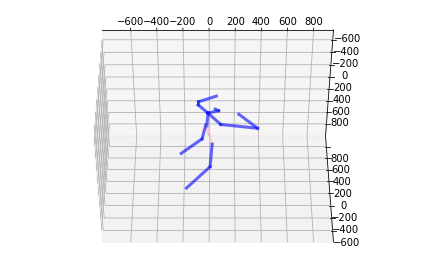

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7fa2b207f4d0> (for post_run_cell):


NotebookValidationError: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01t\x00\x00\x00\xf8\x08\x06\x00\x00\x00\xfcf\x1dD\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.1.3, http://matplotlib.org/\x80\x001D\x00\x00\x08~IDATx\x9c\xed\xddA\xa8\xa5u\x19\xc7\xf1\xdf\x93V\xcb\x82\xe6.D\xa5+\xe4\xa6\x85\x84^\xa4\xa5\x10\x81\xbap\x16\x15\xd8\xc6\x94d6\x89kW\x05\xeeZ\x05A$Z\xa2\xb6P\xc1\xd5\x04B\x10-\\\x15^!\xc4\x12a\x10\xc4\x8b\x82W\r7\x911\xf0\xb4\x98\x13]\xaeg\xe6\x9e\x999\xc7;\xf7\xe9\xf3\x81\x03\xe7=\xef;\xe7}\x16\x7f\xbe\xbc\xf7p\xce\xbc\xd5\xdd\x01\xe0\xe4\xfb\xc2q\x0f\x00\xc0z\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\\\x7f\\\'>u\xeaTooo\x1f\xd7\xe9\x01N\xa4\xd7^{\xed\xc3\xee\xdeZ\xb6\xef\xd8\x82\xbe\xbd\xbd\x9d\xdd\xdd\xdd\xe3:=\xc0\x89TU\xef\\l\x9f\x8f\\\x00\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x8682\xe8U\xf5tU}PUo\\d\x7fU\xd5/\xab\xea\\U\xbd^U\xb7\xaf\x7fL\x00\x8e\xb2\xca\x15\xfa3I\xee\xbe\xc4\xfe{\x92\xdc\xbax\x9cI\xf2\xeb\xab\x1f\x0b\x80\xcbud\xd0\xbb\xfb\x95$\x1f_\xe2\x90\xd3I\x9e\xeb\x0b\xfe\x9c\xe4\xabUu\xc3\xba\x06\x04`5\xeb\xf8\x0c\xfd\xc6$\xef\x1e\xd8\xde[\xbc\xf6\x19Uu\xa6\xaav\xabjw\x7f\x7f\x7f\r\xa7\x06\xe0\xbf\xd6\x11\xf4Z\xf2\xda\xd2\xbbft\xf7\x93\xdd\xbd\xd3\xdd;[[K\x7f\xb9\n\xc0\x15ZG\xd0\xf7\x92\xdc|`\xfb\xa6$\xef\xad\xe1}\x01\xb8\x0c\xeb\x08\xfa\xd9$\x0f,\xbe\xed\xf2\xed$\x9ft\xf7\xfbkx_\x00.\xc3\x91\xff9WU=\x9f\xe4\xae$\xa7\xaaj/\xc9\xcf\x92|1I\xba\xfb\x89$/\'\xb97\xc9\xb9$\xffL\xf2\xd0\xa6\x86\x05\xe0\xe2\x8e\x0czw\xff\xf0\x88\xfd\x9d\xe4\'k\x9b\x08\x80+\xe2\x97\xa2\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10+\x05\xbd\xaa\xee\xae\xaa\xb7\xaa\xea\\U=\xb6d\xff\x83U\xb5_U\x7f]<\x1e^\xff\xa8\x00\\\xca\xf5G\x1dPU\xd7%\xf9U\x92\xef&\xd9K\xf2jU\x9d\xed\xee\xbf\x1f:\xf4\xc5\xee~d\x033\x02\xb0\x82U\xae\xd0\xefLr\xae\xbb\xdf\xee\xee\x7f\'y!\xc9\xe9\xcd\x8e\x05\xc0\xe5Z%\xe87&y\xf7\xc0\xf6\xde\xe2\xb5\xc3\xbeWU\xafW\xd5KUu\xf3\xb27\xaa\xaa3U\xb5[U\xbb\xfb\xfb\xfbW0.\x00\x17\xb3J\xd0k\xc9k}h\xfb\xf7I\xb6\xbb\xfb\xb6$\x7fL\xf2\xec\xb27\xea\xee\'\xbb{\xa7\xbbw\xb6\xb6\xb6.oR\x00.i\x95\xa0\xef%9x\xc5}S\x92\xf7\x0e\x1e\xd0\xdd\x1fu\xf7\xa7\x8b\xcd\xa7\x92\xdc\xb1\x9e\xf1\x00X\xd5*A\x7f5\xc9\xadUuKU})\xc9\xfdI\xce\x1e<\xa0\xaan8\xb0y_\x927\xd77"\x00\xab8\xf2[.\xdd}\xbe\xaa\x1eI\xf2\x87$\xd7%y\xba\xbb\xffVU\x8f\'\xd9\xed\xee\xb3I\x1e\xad\xaa\xfb\x92\x9cO\xf2q\x92\x07783\x00KT\xf7\xe1\x8f\xc3?\x1f;;;\xbd\xbb\xbb{,\xe7\x068\xa9\xaa\xea\xb5\xee\xdeY\xb6\xcf/E\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!V\nzU\xdd]UoU\xd5\xb9\xaazl\xc9\xfe/W\xd5\x8b\x8b\xfd\x7f\xa9\xaa\xedu\x0f\n\xc0\xa5\x1d\x19\xf4\xaa\xba.\xc9\xaf\x92\xdc\x93\xe4\x9bI~XU\xdf<t\xd8\x8f\x93\xfc\xa3\xbb\xbf\x91\xe4\x17I~\xbe\xeeA\x01\xb8\xb4U\xae\xd0\xefLr\xae\xbb\xdf\xee\xee\x7f\'y!\xc9\xe9C\xc7\x9cN\xf2\xec\xe2\xf9KI\xbeSU\xb5\xbe1\x018\xca*A\xbf1\xc9\xbb\x07\xb6\xf7\x16\xaf-=\xa6\xbb\xcf\'\xf9$\xc9\xd7\x0e\xbfQU\x9d\xa9\xaa\xdd\xaa\xda\xdd\xdf\xdf\xbf\xb2\x89\x01Xj\x95\xa0/\xbb\xd2\xee+8&\xdd\xfddw\xeft\xf7\xce\xd6\xd6\xd6*\xf3\x01\xb0\xa2U\x82\xbe\x97\xe4\xe6\x03\xdb7%y\xefb\xc7T\xd5\xf5I\xbe\x92\xe4\xe3u\x0c\x08\xc0jV\t\xfa\xabIn\xad\xaa[\xaa\xeaKI\xeeOr\xf6\xd01g\x93\xfch\xf1\xfc\xfbI\xfe\xd4\xdd\x9f\xb9B\x07`s\xae?\xea\x80\xee>_U\x8f$\xf9C\x92\xeb\x92<\xdd\xdd\x7f\xab\xaa\xc7\x93\xecv\xf7\xd9$\xbfM\xf2\xbb\xaa:\x97\x0bW\xe6\xf7orh\x00>\xeb\xc8\xa0\'Iw\xbf\x9c\xe4\xe5C\xaf\xfd\xf4\xc0\xf3\x7f%\xf9\xc1zG\x03\xe0r\xf8\xa5(\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\xd4q}\xbb\xb0\xaa\xf6\x93\xbcs\x85\xff\xfcT\x92\x0f\xd78\x0e\x1cd}\xb1iW\xb3\xc6\xbe\xde\xddK\x7f\x99ylA\xbf\x1aU\xb5\xdb\xdd;\xc7=\x073Y_l\xda\xa6\xd6\x98\x8f\\\x00\x86\x10t\x80!Nj\xd0\x9f<\xee\x01\x18\xcd\xfab\xd36\xb2\xc6N\xe4g\xe8\x00|\xd6I\xbdB\x07\xe0\x10A\x07\x18\xe2\x9a\x0e\xba\x9bS\xb3I+\xac\xaf\x07\xabj\xbf\xaa\xfe\xbax<|\x1csr2U\xd5\xd3U\xf5AU\xbdq\x91\xfdUU\xbf\\\xac\xbf\xd7\xab\xea\xf6\xab=\xe75\x1bt7\xa7f\x93V\\_I\xf2bw\x7fk\xf1\xf8\xcd\xe7:$\'\xdd3I\xee\xbe\xc4\xfe{\x92\xdc\xbax\x9cI\xf2\xeb\xab=\xe15\x1b\xf4\xb895\x9b\xb5\xca\xfa\x82+\xd6\xdd\xaf\xe4\xd2wn;\x9d\xe4\xb9\xbe\xe0\xcfI\xbeZU7\\\xcd9\xaf\xe5\xa0\xaf\xed\xe6\xd4\xb0\xc4*\xeb+I\xbe\xb7\xf8s\xf8\xa5\xaa\xbay\xc9~\xb8R\xab\xae\xc1\x95]\xcbA_\xdb\xcd\xa9a\x89U\xd6\xce\xef\x93lw\xf7mI\xfe\x98\xff\xfd5\x08\xeb\xb0\xf6~]\xcbAwsj6\xe9\xc8\xf5\xd5\xdd\x1fu\xf7\xa7\x8b\xcd\xa7\x92\xdc\xf19\xcd\xc6\xff\x87U\x1awY\xae\xe5\xa0\xbb95\x9bt\xe4\xfa:\xf4y\xe6}I\xde\xfc\x1c\xe7c\xbe\xb3I\x1eX|\xdb\xe5\xdbI>\xe9\xee\xf7\xaf\xe6\rW\xba\xa7\xe8qpsj6i\xc5\xf5\xf5hU\xdd\x97\xe4|.\xac\xaf\x07\x8fm`N\x9c\xaaz>\xc9]INU\xd5^\x92\x9f%\xf9b\x92t\xf7\x13\xb9p\x9f\xe6{\x93\x9cK\xf2\xcf$\x0f]\xf59]\xd0\x02\xccp-\x7f\xe4\x02\xc0e\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x88\xff\x00\xf9x\xdb\xf2\xab\xf0\x86\x11\x00\x00\x00\x00IEND\xaeB`\x82' is not valid under any of the given schemas

Failed validating 'oneOf' in notebook['properties']['data']['additionalProperties']:

On instance['data']['image/png']:
(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01t\x00\x00\x00\xf8'
 b'\x08\x06\x00\x00\x00\xfcf\x1dD\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d'
 b'\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd'
 b'~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.1.3, http://matpl'
 b'otlib.org/\x80\x001D\x00\x00\x08~IDATx\x9c\xed\xddA\xa8\xa5u\x19\xc7'
 b'\xf1\xdf\x93V\xcb\x82\xe6.D\xa5+\xe4\xa6\x85\x84^\xa4\xa5\x10\x81'
 b'\xbap\x16\x15\xd8\xc6\x94d6\x89kW\x05\xeeZ\x05A$Z\xa2\xb6P\xc1\xd5'
 b'\x04B\x10-\\\x15^!\xc4\x12a\x10\xc4\x8b\x82W\r7\x911\xf0\xb4\x98\x13'
 b']\xaeg\xe6\x9e\x999\xc7;\xf7\xe9\xf3\x81\x03\xe7=\xef;\xe7}'
 b'\x16\x7f\xbe\xbc\xf7p\xce\xbc\xd5\xdd\x01\xe0\xe4\xfb\xc2q\x0f\x00\xc0z'
 b"\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\\\x7f\\'>u\xeaTo"
 b'oo\x1f\xd7\xe9\x01N\xa4\xd7^{\xed\xc3\xee\xdeZ\xb6\xef\xd8\x82'
 b'\xbe\xbd\xbd\x9d\xdd\xdd\xdd\xe3:=\xc0\x89TU\xef\\l\x9f\x8f\\\x00\x86\x10t'
 b'\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x8682\xe8U\xf5tU}PUo\\d\x7fU'
 b'\xd5/\xab\xea\\U\xbd^U\xb7\xaf\x7fL\x00\x8e\xb2\xca\x15\xfa3I\xee\xbe\xc4'
 b'\xfe{\x92\xdc\xbax\x9cI\xf2\xeb\xab\x1f\x0b\x80\xcbud\xd0\xbb\xfb'
 b'\x95$\x1f_\xe2\x90\xd3I\x9e\xeb\x0b\xfe\x9c\xe4\xabUu\xc3\xba\x06'
 b'\x04`5\xeb\xf8\x0c\xfd\xc6$\xef\x1e\xd8\xde[\xbc\xf6\x19Uu\xa6\xaav\xabj'
 b'w\x7f\x7f\x7f\r\xa7\x06\xe0\xbf\xd6\x11\xf4Z\xf2\xda\xd2\xbbft\xf7'
 b'\x93\xdd\xbd\xd3\xdd;[[K\x7f\xb9\n\xc0\x15ZG\xd0\xf7\x92\xdc|`\xfb\xa6'
 b'$\xef\xad\xe1}\x01\xb8\x0c\xeb\x08\xfa\xd9$\x0f,\xbe\xed\xf2\xed$'
 b'\x9ft\xf7\xfbkx_\x00.\xc3\x91\xff9WU=\x9f\xe4\xae$\xa7\xaaj/\xc9\xcf\x92|'
 b"1I\xba\xfb\x89$/'\xb97\xc9\xb9$\xffL\xf2\xd0\xa6\x86\x05\xe0\xe2\x8e\x0c"
 b"zw\xff\xf0\x88\xfd\x9d\xe4'k\x9b\x08\x80+\xe2\x97\xa2\x00C\x08"
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c'
 b'!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08'
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c'
 b'!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08'
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c'
 b'!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08'
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c'
 b'!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08'
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c'
 b'!\xe8\x00C\x08:\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08'
 b':\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10\x82\x0e'
 b'0\x84\xa0\x03\x0c!\xe8\x00C\x08:\xc0\x10+\x05\xbd\xaa\xee\xae\xaa'
 b'\xb7\xaa\xea\\U=\xb6d\xff\x83U\xb5_U\x7f]<\x1e^\xff\xa8\x00\\\xca'
 b'\xf5G\x1dPU\xd7%\xf9U\x92\xef&\xd9K\xf2jU\x9d\xed\xee\xbf\x1f:\xf4'
 b"\xc5\xee~d\x033\x02\xb0\x82U\xae\xd0\xefLr\xae\xbb\xdf\xee\xee\x7f'y!"
 b'\xc9\xe9\xcd\x8e\x05\xc0\xe5Z%\xe87&y\xf7\xc0\xf6\xde\xe2\xb5\xc3'
 b'\xbeWU\xafW\xd5KUu\xf3\xb27\xaa\xaa3U\xb5[U\xbb\xfb\xfb\xfbW0.\x00\x17'
 b'\xb3J\xd0k\xc9k}h\xfb\xf7I\xb6\xbb\xfb\xb6$\x7fL\xf2\xec\xb27\xea\xee'
 b"'\xbb{\xa7\xbbw\xb6\xb6\xb6.oR\x00.i\x95\xa0\xef%9x\xc5}S\x92\xf7\x0e\x1e"
 b'\xd0\xdd\x1fu\xf7\xa7\x8b\xcd\xa7\x92\xdc\xb1\x9e\xf1\x00X\xd5*A\x7f'
 b'5\xc9\xadUuKU})\xc9\xfdI\xce\x1e<\xa0\xaan8\xb0y_\x927\xd77"\x00\xab8\xf2['
 b".\xdd}\xbe\xaa\x1eI\xf2\x87$\xd7%y\xba\xbb\xffVU\x8f'\xd9\xed\xee\xb3"
 b'I\x1e\xad\xaa\xfb\x92\x9cO\xf2q\x92\x07783\x00KT\xf7\xe1\x8f\xc3?\x1f'
 b';;;\xbd\xbb\xbb{,\xe7\x068\xa9\xaa\xea\xb5\xee\xdeY\xb6\xcf/E\x01\x86'
 b'\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A'
 b'\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01'
 b'\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08'
 b'A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t'
 b'\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18'
 b'B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04'
 b'\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01'
 b'\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08'
 b'A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t'
 b'\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18'
 b'B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04'
 b'\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01'
 b'\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08'
 b'A\x07\x18B\xd0\x01\x86\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t'
 b'\x80!V\nzU\xdd]UoU\xd5\xb9\xaazl\xc9\xfe/W\xd5\x8b\x8b\xfd\x7f\xa9\xaa\xed'
 b'u\x0f\n\xc0\xa5\x1d\x19\xf4\xaa\xba.\xc9\xaf\x92\xdc\x93\xe4\x9bI~XU\xdf<'
 b't\xd8\x8f\x93\xfc\xa3\xbb\xbf\x91\xe4\x17I~\xbe\xeeA\x01\xb8\xb4U'
 b"\xae\xd0\xefLr\xae\xbb\xdf\xee\xee\x7f'y!\xc9\xe9C\xc7\x9cN"
 b'\xf2\xec\xe2\xf9KI\xbeSU\xb5\xbe1\x018\xca*A\xbf1\xc9\xbb\x07\xb6\xf7'
 b"\x16\xaf-=\xa6\xbb\xcf'\xf9$\xc9\xd7\x0e\xbfQU\x9d\xa9\xaa\xdd"
 b'\xaa\xda\xdd\xdf\xdf\xbf\xb2\x89\x01Xj\x95\xa0/\xbb\xd2\xee+8&\xdd\xfddw'
 b'\xeft\xf7\xce\xd6\xd6\xd6*\xf3\x01\xb0\xa2U\x82\xbe\x97\xe4\xe6\x03\xdb'
 b'7%y\xefb\xc7T\xd5\xf5I\xbe\x92\xe4\xe3u\x0c\x08\xc0jV\t\xfa\xabIn\xad\xaa['
 b'\xaa\xeaKI\xeeOr\xf6\xd01g\x93\xfch\xf1\xfc\xfbI\xfe\xd4\xdd\x9f\xb9B'
 b'\x07`s\xae?\xea\x80\xee>_U\x8f$\xf9C\x92\xeb\x92<\xdd\xdd\x7f\xab\xaa'
 b'\xc7\x93\xecv\xf7\xd9$\xbfM\xf2\xbb\xaa:\x97\x0bW\xe6\xf7orh\x00>\xeb'
 b"\xc8\xa0'Iw\xbf\x9c\xe4\xe5C\xaf\xfd\xf4\xc0\xf3\x7f%\xf9\xc1zG\x03\xe0r"
 b'\xf8\xa5(\xc0\x10\x82\x0e0\x84\xa0\x03\x0c!\xe8\x00C\xd4q}\xbb'
 b'\xb0\xaa\xf6\x93\xbcs\x85\xff\xfcT\x92\x0f\xd78\x0e\x1cd}\xb1i'
 b'W\xb3\xc6\xbe\xde\xddK\x7f\x99ylA\xbf\x1aU\xb5\xdb\xdd;\xc7=\x073Y'
 b'_l\xda\xa6\xd6\x98\x8f\\\x00\x86\x10t\x80!Nj\xd0\x9f<\xee\x01\x18\xcd\xfa'
 b'b\xd36\xb2\xc6N\xe4g\xe8\x00|\xd6I\xbdB\x07\xe0\x10A\x07\x18\xe2\x9a\x0e'
 b'\xba\x9bS\xb3I+\xac\xaf\x07\xabj\xbf\xaa\xfe\xbax<|\x1csr2U\xd5\xd3U\xf5A'
 b'U\xbdq\x91\xfdUU\xbf\\\xac\xbf\xd7\xab\xea\xf6\xab=\xe75\x1bt7\xa7f'
 b"\x93V\\_I\xf2bw\x7fk\xf1\xf8\xcd\xe7:$'\xdd3I\xee\xbe\xc4\xfe{\x92\xdc\xba"
 b'x\x9cI\xf2\xeb\xab=\xe15\x1b\xf4\xb895\x9b\xb5\xca\xfa\x82+'
 b'\xd6\xdd\xaf\xe4\xd2wn;\x9d\xe4\xb9\xbe\xe0\xcfI\xbeZU7\\\xcd9\xaf\xe5'
 b'\xa0\xaf\xed\xe6\xd4\xb0\xc4*\xeb+I\xbe\xb7\xf8s\xf8\xa5\xaa\xbay'
 b'\xc9~\xb8R\xab\xae\xc1\x95]\xcbA_\xdb\xcd\xa9a\x89U\xd6\xce\xef\x93lw'
 b'\xf7mI\xfe\x98\xff\xfd5\x08\xeb\xb0\xf6~]\xcbAwsj6\xe9\xc8\xf5\xd5'
 b'\xdd\x1fu\xf7\xa7\x8b\xcd\xa7\x92\xdc\xf19\xcd\xc6\xff\x87U\x1awY'
 b'\xae\xe5\xa0\xbb95\x9bt\xe4\xfa:\xf4y\xe6}I\xde\xfc\x1c\xe7c\xbe\xb3I'
 b'\x1eX|\xdb\xe5\xdbI>\xe9\xee\xf7\xaf\xe6\rW\xba\xa7\xe8qpsj6i\xc5\xf5\xf5h'
 b'U\xdd\x97\xe4|.\xac\xaf\x07\x8fm`N\x9c\xaaz>\xc9]INU\xd5^\x92\x9f%\xf9'
 b'b\x92t\xf7\x13\xb9p\x9f\xe6{\x93\x9cK\xf2\xcf$\x0f]\xf59]\xd0\x02\xcc'
 b'p-\x7f\xe4\x02\xc0e\x10t\x80!\x04\x1d`\x08A\x07\x18B\xd0\x01\x86\x10t'
 b'\x80!\x04\x1d`\x88\xff\x00\xf9x\xdb\xf2\xab\xf0\x86\x11\x00\x00\x00\x00'
 b'IEND\xaeB`\x82')

In [7]:
plot.plot_3d(_3d_target, color='blue', mode="show",
                show_ticks=True, labels=False, mean_root=True)

In [10]:
print(pjpe.shape)
idx_max = torch.argmax(pjpe)
print(idx_max)
print(pjpe[idx_max])
avg_mpjpe

torch.Size([8695])
tensor(5195, device='cuda:0')
tensor(568.5425, device='cuda:0')


452.42169189453125

In [17]:
pose3d = t_data["target_3d"].cpu().numpy()
pose3d.shape

(8695, 17, 3)

# Check bone length ratios

In [26]:
js = ('Pelvis', 'R_Hip', 'R_Knee', 'R_Ankle', 'L_Hip', 'L_Knee', 'L_Ankle', 'Torso',
                    'Neck', 'Nose', 'Head', 'L_Shoulder', 'L_Elbow', 'L_Wrist', 'R_Shoulder', 'R_Elbow',        'R_Wrist')
        
head2neck = np.linalg.norm(
    pose3d[:,js.index('Head'),:] - pose3d[:,js.index('Neck'),:], axis=1, keepdims=True)
neck2torso = np.linalg.norm(
    pose3d[:,js.index('Neck'),:] - pose3d[:,js.index('Torso'),:], axis=1, keepdims=True)
torso2root = np.linalg.norm(
    pose3d[:,js.index('Torso'),:] - pose3d[:,js.index('Pelvis'),:], axis=1, keepdims=True)

dist = head2neck+neck2torso+torso2root
print("above root", dist.min(), dist.max(), np.mean(dist))

head2neck = np.linalg.norm(
    pose3d[:,js.index('R_Hip'),:] - pose3d[:,js.index('R_Knee'),:], axis=1, keepdims=True)
neck2torso = np.linalg.norm(
    pose3d[:,js.index('R_Knee'),:] - pose3d[:,js.index('R_Ankle'),:], axis=1, keepdims=True)
# torso2root = np.linalg.norm(
#     pose3d[:,js.index('Torso'),:] - pose3d[:,js.index('Pelvis'),:], axis=1, keepdims=True)

dist2 = head2neck+neck2torso#+torso2root
print("below root", dist2.min(), dist2.max(), np.mean(dist2))

above root 630.91187 733.9287 701.97
below root 922.1635 940.818 932.91626


In [1]:
print(1)

1


# Check h5py files

In [1]:
import h5py
annotations_h5 = h5py.File(f'../src/data/h36m17_911.h5', 'r')

for key in annotations_h5.keys():
    print(key)

action
bbox
cam_R
cam_T
cam_c
cam_f
cam_k
cam_p
camera
idx
pose2d
pose3d
pose3d_global
subaction
subject


In [2]:
annotations_h5["action"]

<HDF5 dataset "action": shape (8695,), type "<i8">

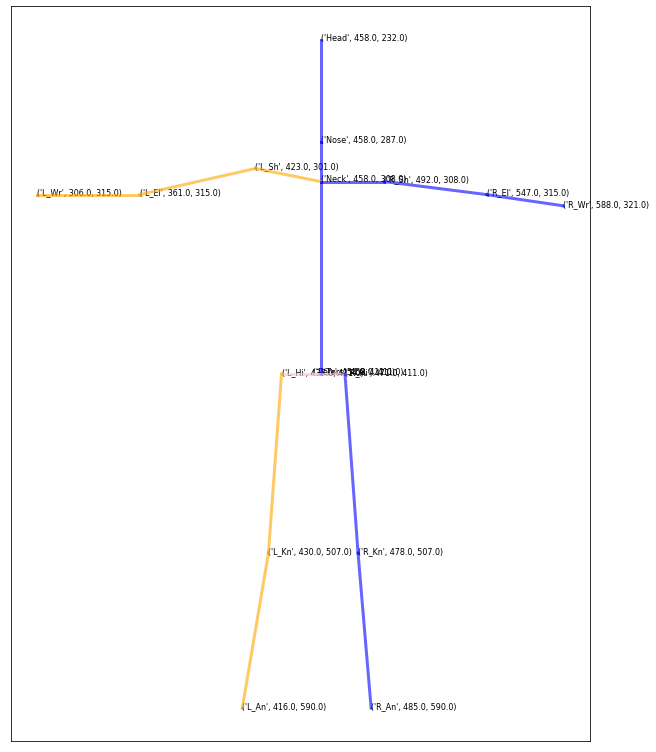

In [40]:
import numpy as np
import src.viz.mpl_plots as plot

pose = np.array([[485., 590.],
       [478., 507.],
       [471., 411.],
       [437., 411.],
       [430., 507.],
       [416., 590.],
       [458., 411.],
       [458., 308.],
       [458., 287.],
       [458., 232.],
       [588., 321.],
       [547., 315.],
       [492., 308.],
       [423., 301.],
       [361., 315.],
       [306., 315.]])


plot.plot_2d(pose, mean_root=True, labels=True)

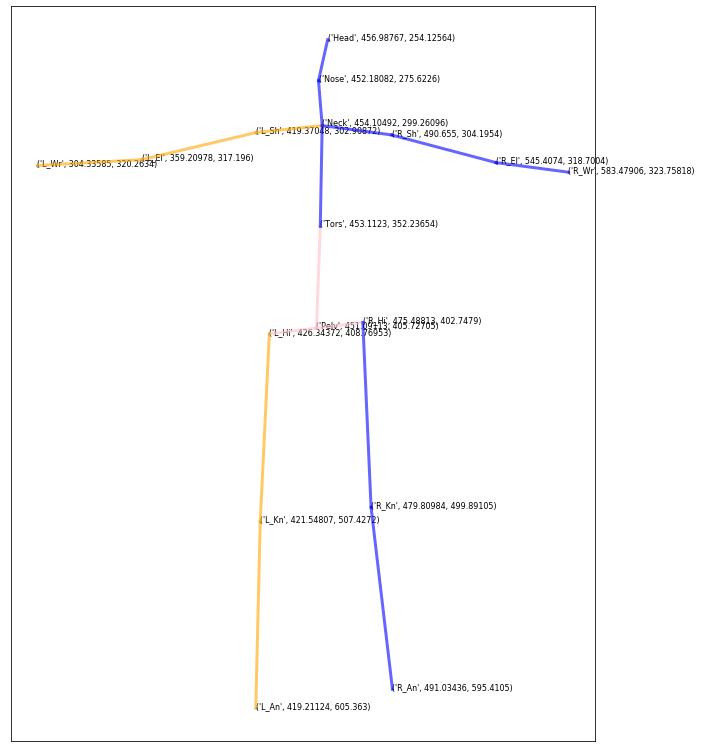

In [16]:
import numpy as np
import src.viz.mpl_plots as plot

pose = np.array([[451.09113, 405.72705],
       [475.48813, 402.7479 ],
       [479.80984, 499.89105],
       [491.03436, 595.4105 ],
       [426.34372, 408.76953],
       [421.54807, 507.4272 ],
       [419.21124, 605.363  ],
       [453.1123 , 352.23654],
       [454.10492, 299.26096],
       [452.18082, 275.6226 ],
       [456.98767, 254.12564],
       [419.37048, 302.90872],
       [359.20978, 317.196  ],
       [304.33585, 320.2634 ],
       [490.655  , 304.1954 ],
       [545.4074 , 318.7004 ],
       [583.47906, 323.75818]])

plot.plot_2d(pose, mean_root=True)



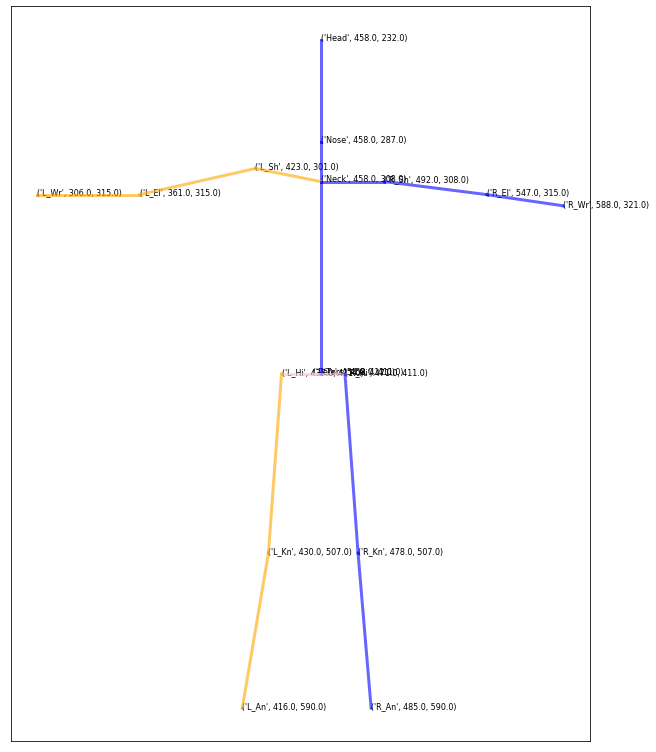

In [54]:
swap_ind = np.array([2,1,0,3,4,5,6,7,8,9,13,14,15,12,11,10])

a = np.array([[[485., 590.],
       [478., 507.],
       [471., 411.],
       [437., 411.],
       [430., 507.],
       [416., 590.],
       [458., 411.],
       [458., 308.],
       [458., 287.],
       [458., 232.],
       [588., 321.],
       [547., 315.],
       [492., 308.],
       [423., 301.],
       [361., 315.],
       [306., 315.]]])

plot.plot_2d(a[:,swap_ind][0], mean_root=True, labels=True)

In [55]:
a.shape

(1, 16, 2)

In [14]:
import numpy as np
a = np.zeros((2,16,2))
b = np.ones((1,2))

In [29]:
c = np.insert(a,0,b,1)

In [32]:
print(a.shape, b.shape, c.shape)


(2, 16, 2) (1, 2) (2, 17, 2)


In [31]:
c

array([[[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]])